# Residential Photovoltaic Installations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()

# read
residential_pv = pd.read_csv('Capstone/residential_pv.csv', sep=',', low_memory=False)

### Correlation of Cost and Size
Explore the relationship between the two variables, did this correlation occur purely by chance?

In [2]:
# =============================================================================
# Correlation of Cost and Size
# =============================================================================
# explore the relationship, did this correlation occur PURELY BY CHANCE?

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x,y)
    # Return entry [0,1]
    return corr_mat[0,1]

def bootstrap_replicate_1d(data, func):
  '''Generate boostrap replicate of one-dim data '''
  bs_sample = np.random.choice(data, len(data))
  return func(bs_sample)

# generate many bootstrap replicates from the data set
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates




In [3]:
# remove all missing values before computing pearson r
clean_pv = residential_pv
clean_pv[clean_pv['cost'].isnull().values] = np.nan
clean_pv = residential_pv.dropna(axis=0, how='all').reset_index(drop=True)
print(pearson_r(clean_pv['size_kw'].values, clean_pv['cost']))
print(pearson_r(clean_pv['annual_pv_prod'].values, clean_pv['cost']))


0.714074107555
0.683263459413


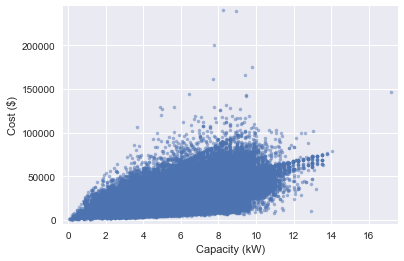

In [4]:
size = clean_pv['size_kw'].values
cost = clean_pv['cost'].values

# Plot
plt.plot(size, cost, marker='.', linestyle='none', alpha=0.5)
plt.margins(0.02)
plt.xlabel('Capacity (kW)')
plt.ylabel('Cost ($)')
plt.show()


slope = 4407.38884113 change in price per kilowatt
intercept = 4944.94582887 dollars


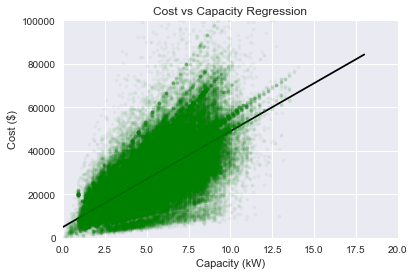

For a 10 kilowatt system is $49018.83


In [5]:
# calculate slope and intercept
# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(size, cost, deg=1)

# Print the results to the screen
print('slope =', a, 'change in price per kilowatt')
print('intercept =', b, 'dollars')

# Make theoretical line to plot
x = np.array([0,18])
y = a * x + b

# Add regression line to plot
plt.plot(x, y, color='black')
plt.plot(size, cost, marker='.', linestyle='none', alpha=0.05, color='green')
plt.margins(0.02)
plt.xlabel('Capacity (kW)')
plt.ylabel('Cost ($)')
plt.title('Cost vs Capacity Regression')
plt.margins(0.5)
plt.xlim([0,20])
plt.ylim([0,100000])
plt.show()


# when x = 10 kilowatts or 10,000 watts
x = 10
y = a * x + b
print('For a ' + str(x) + ' kilowatt system is ' + str('$') + str(round(y, 2)))

In [14]:
# functions for individual states
date_time = '%m/%d/%Y'
datetime = pd.to_datetime(clean_pv['date_installed'], format=date_time)
pv_pop_date = clean_pv.set_index(datetime)


def state_cost_cap(df, state_name, sys_cap):
  state = df[df['state'] == state_name]
  if len(state) < 1:
    print('No data available for state.')
  else:
    print('Amount of state data:', len(state))
    print('Correlation between system capacity and cost:', pearson_r(state['size_kw'], state['cost']))
    a, b = np.polyfit(state['size_kw'], state['cost'], deg=1)
    x = np.array([0,state['size_kw'].max()])
    y = a * x + b
    plt.scatter(state['size_kw'], state['cost'], marker='.',  alpha=0.5)
    plt.plot(x, y, color='black')
    plt.margins(0.02)
    plt.xlabel('Cap')
    plt.ylabel('Cost ($)')
    plt.show()
    x = sys_cap
    y = a * x + b
    print('Gross cost of a ' + str(x) + ' kilowatt system is ' + str('$') + str(round(y, 2)))
    print('slope =', a, 'change in price per kilowatt')
    print('intercept =', b, 'dollars')


Amount of state data: 8810
Correlation between system capacity and cost: 0.718726768698


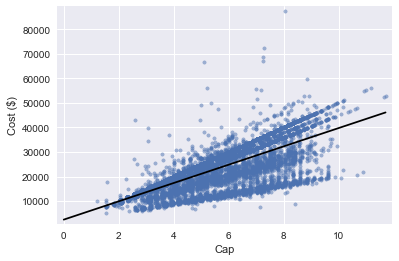

Gross cost of a 6 kilowatt system is $24838.75
slope = 3735.98962085 change in price per kilowatt
intercept = 2422.81353855 dollars
None
Amount of state data: 214
Correlation between system capacity and cost: 0.736723498063


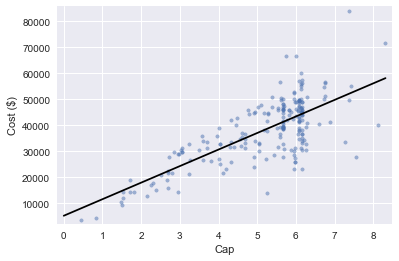

Gross cost of a 6 kilowatt system is $43393.16
slope = 6358.88616874 change in price per kilowatt
intercept = 5239.83984159 dollars
None


In [17]:
# filter by years,state and compare
print(state_cost_cap(pv_pop_date['2015':'2018'], 'nevada', 6))
print(state_cost_cap(pv_pop_date['2008':'2009'], 'nevada', 6))


### Confidence Interval

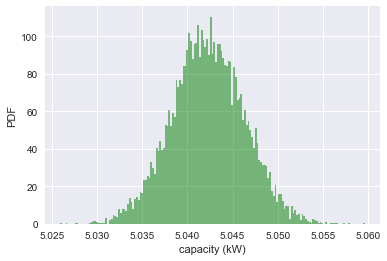

Confidence interval: [ 5.03434561  5.05016681]
Mean of bootstrap reps: 5.04227555867
Standard Deviation of bootstrap reps: 0.00401712097517


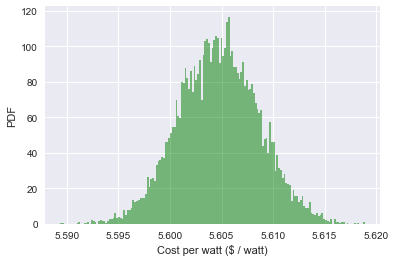

Confidence interval: [ 5.59709966  5.61242447]
Mean of bootstrap reps: 5.60470714312
Standard Deviation of bootstrap reps: 0.00389541787635


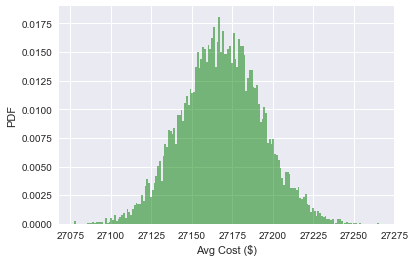

Confidence interval: [ 27120.35804504  27217.32993442]
Mean of bootstrap reps: 27168.3707694
Standard Deviation of bootstrap reps: 24.7471995361
None None None


In [6]:
# =============================================================================
# Cost - Confidence Interval
# =============================================================================

size = clean_pv['size_kw'].values
cost = clean_pv['cost'].values
cost_per_watt = clean_pv['cost_per_watt'].values

def bs_reps_plot(data, func, c_int, size=100, label='data'):
  data_bs_reps = draw_bs_reps(data, func, size)
  n_bins = int(np.sqrt(len(data))/3)
  plt.hist(data_bs_reps, bins=n_bins, normed=True, alpha=0.5, color='green')
  plt.xlabel(label)
  plt.ylabel('PDF')
  plt.show()
  conf_int = np.percentile(data_bs_reps, c_int)
  print('Confidence interval:', conf_int)
  print('Mean of bootstrap reps:', np.mean(data_bs_reps))
  print('Standard Deviation of bootstrap reps:', np.std(data_bs_reps))

sys_cap = bs_reps_plot(size, np.mean, [2.5, 97.5], 10000, label='capacity (kW)')
sys_cost_per_watt = bs_reps_plot(cost_per_watt, np.mean, [2.5, 97.5], 10000, label='Cost per watt ($ / watt)')
sys_cost = bs_reps_plot(cost, np.mean, [2.5, 97.5], 10000, label='Avg Cost ($)')
print(sys_cap, sys_cost_per_watt, sys_cost)

### Hypothesis Test of Pearson Correlation

**Hypothesis:**
- **H0**: The observed correlation between system capacity and installation cost occurred purely by chance
- **HA**: The observed correlation between system capacity and installation cost didn't occur purely by chance
- **alpha**: 0.05


**Approach:**

1. simulate hypothesis that they are completely independent of each other
2. permute size/capacity; leave cost fixed
3. for each permutation(shuffling data), compute Pearson correlation
4. asses how many replicates have Pearson correlation greater than observed


In [7]:
size = clean_pv['size_kw'].values
cost = clean_pv['cost'].values

# observed correlation: r_obs
r_obs = pearson_r(size, cost)

# initialize permutation replicates
permutation_reps = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    size_permuted = np.random.permutation(size)
    # Compute Pearson correlation
    permutation_reps[i] = pearson_r(size_permuted, cost)

# Compute p-value: p
p = np.sum(permutation_reps > r_obs)/len(permutation_reps)
print('p-val =', p)


p-val = 0.0


In [8]:
print('Observed correlation:', r_obs)
print('p-val =', p)


Observed correlation: 0.714074107555
p-val = 0.0


The p-value of zero indicates that the probability of having the observed correlation (0.7141) occur purely by chance would be zero out of 10,000 samples. As a result, we must reject the null hypotheses and accept the alternative hypothesis that the correlation did not occur by random chance. 
